# Détection d'anomalies avec les auto-encodeurs variationels
*Cas d'usage : lutte contre la fraude*

## Auto-encodeurs variationnels

Les auto-encodeurs sont des réseaux de neurones artificiels. L'objectif d'un auto-encodeur est de reconstruire ses entrées `X`

Les auto-encodeurs font partie de la famille des algorithmes dits non supervisés dans la mesure où il n'y pas de variables `Y` à prédire.

Les auto-encodeurs variationnels ont la particularité de pouvoir simuler le processus de génération de données. En sens les auto-encodeurs variationnels font parties des modèles génératifs.

Ils sont composés principalement de trois parties :

* **Encodeur** : produit une représentation compacte des données d’entrées
* **Espace latent** : n'est plus fixe mais généré à partir de distributions gaussiennes
* **Décodeur** : reconstruit les données initiales à partir de l’input (ex: des données bruitées)
<img src = "https://i.stack.imgur.com/yzwpd.png" title = "google logo" width = "600"  height = "200" >

## Détection d'anomalies

* Les auto-encodeurs peuvent être utilisés pour détecter des anomalies car on suppose que celles-ci seront difficile à prédire par un modèle.

## Détection de la fraude

 1. Apprendre à reconstruire les transactions saines
 2. Reconstruire les transactions de l'ensemble des données test
     * Si l'erreur de reconstruction est importante, la transaction sera considérée comme frauduleuse  

## Données

Les données sont disponibles [ici.](https://github.com/GuansongPang/anomaly-detection-datasets)


**Note :** Je mets plutôt l'accès sur les auto-encodeurs, je saute volontairement les étapes d'exploration de données et de feature engineering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, precision_recall_curve,
                             auc, roc_curve, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

sns.set()
rcParams['figure.figsize'] = 7, 7
random_seed = 123450
class_names = ["Saines", "Fraudes"]

from numpy.random import seed
seed(random_seed)
from tensorflow.random import set_seed
set_seed(random_seed)

In [2]:
path_data = 'data/creditcard.csv'
target = 'Class'
col2drop = [target, 'Time']

dfm = pd.read_csv(path_data)
dfm["Class"] = dfm["Class"].map(lambda x: float(x.replace("'", '')))
dfm['Amount'] = StandardScaler().fit_transform(dfm['Amount'].values.reshape(-1, 1))

dfm.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
Time,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,4.000000,7.000000,7.000000,9.000000
V1,-1.359807,1.191857,-1.358354,-0.966272,-1.158233,-0.425966,1.229658,-0.644269,-0.894286,-0.338262
V2,-0.072781,0.266151,-1.340163,-0.185226,0.877737,0.960523,0.141004,1.417964,0.286157,1.119593
V3,2.536347,0.166480,1.773209,1.792993,1.548718,1.141109,0.045371,1.074380,-0.113192,1.044367
V4,1.378155,0.448154,0.379780,-0.863291,0.403034,-0.168252,1.202613,-0.492199,-0.271526,-0.222187
V5,-0.338321,0.060018,-0.503198,-0.010309,-0.407193,0.420987,0.191881,0.948934,2.669599,0.499361
V6,0.462388,-0.082361,1.800499,1.247203,0.095921,-0.029728,0.272708,0.428118,3.721818,-0.246761
V7,0.239599,-0.078803,0.791461,0.237609,0.592941,0.476201,-0.005159,1.120631,0.370145,0.651583
V8,0.098698,0.085102,0.247676,0.377436,-0.270533,0.260314,0.081213,-3.807864,0.851084,0.069539
V9,0.363787,-0.255425,-1.514654,-1.387024,0.817739,-0.568671,0.464960,0.615375,-0.392048,-0.736727


### Séparation des données en apprentissage / validation / test

In [3]:
train, test = train_test_split(dfm, test_size=0.2, train_size=0.8, stratify=dfm[target], random_state=random_seed)
train, valid = train_test_split(train, test_size=0.2, train_size=0.8, stratify=train[target], random_state=random_seed)
train = train[train[target] == 0]

X_train = train.drop(col2drop, axis=1).to_numpy()
Y_train = train[target]

X_valid = valid.drop(col2drop, axis=1).to_numpy()
Y_valid = valid[target]

X_test = test.drop(col2drop, axis=1).to_numpy()
Y_test = test[target]

In [4]:
nb_epoch = 100 
batch_size = 128

**Création de la couche de simpling**

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

**Création de l'encodeur**

In [6]:
class Encoder(layers.Layer):
    """Maps digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = keras.Sequential(
            [
             layers.Dense(15, activation='tanh'),
             layers.Dense(8, activation='tanh'),
        ])       
        self.dense_mean = layers.Dense(8)
        self.dense_log_var = layers.Dense(8)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

**Création du décodeur**

In [7]:
class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = keras.Sequential(
            [
             layers.Dense(8, activation='tanh'),
             layers.Dense(15, activation='tanh')
        ]) 
        self.dense_output = layers.Dense(29, activation='tanh')

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)

**Création de l'auto-encodeur**

In [8]:
class VariationalAutoEncoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

In [9]:
vae = VariationalAutoEncoder()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())

In [10]:
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

### Fitting du modèle

In [11]:
history = vae.fit(X_train, X_train,
                  epochs=nb_epoch,
                  batch_size=batch_size, 
                  shuffle=True,
                  validation_data=(X_valid, X_valid), 
                  verbose=1, callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
1422/1422 [==============================] - 3s 2ms/step - loss: 1.0775 - val_loss: 1.1463
Epoch 2/100
1422/1422 [==============================] - 2s 2ms/step - loss: 1.0355 - val_loss: 1.1433
Epoch 3/100
1422/1422 [==============================] - 2s 2ms/step - loss: 1.0221 - val_loss: 1.1427
Epoch 4/100
1422/1422 [==============================] - 2s 1ms/step - loss: 1.0060 - val_loss: 1.1425
Epoch 5/100
1422/1422 [==============================] - 2s 1ms/step - loss: 1.0128 - val_loss: 1.1419
Epoch 6/100
1422/1422 [==============================] - 2s 1ms/step - loss: 1.0207 - val_loss: 1.1417
Epoch 7/100
1422/1422 [==============================] - 2s 1ms/step - loss: 1.0271 - val_loss: 1.1399
Epoch 8/100
1422/1422 [==============================] - 2s 1ms/step - loss: 1.0374 - val_loss: 1.1381
Epoch 9/100
1422/1422 [==============================] - 2s 2ms/step - loss: 1.0107 - val_loss: 1.1344
Epoch 10/100
1422/1422 [==============================] - 2s 2ms/step - l

Epoch 76/100
1422/1422 [==============================] - 2s 1ms/step - loss: 0.9981 - val_loss: 1.1165
Epoch 77/100
1422/1422 [==============================] - 2s 2ms/step - loss: 1.0046 - val_loss: 1.1161
Epoch 78/100
1422/1422 [==============================] - 2s 1ms/step - loss: 0.9956 - val_loss: 1.1168
Epoch 79/100
1422/1422 [==============================] - 2s 1ms/step - loss: 1.0008 - val_loss: 1.1148
Epoch 80/100
1422/1422 [==============================] - 2s 1ms/step - loss: 1.0058 - val_loss: 1.1159 ETA
Epoch 81/100
1422/1422 [==============================] - 2s 1ms/step - loss: 1.0088 - val_loss: 1.1152
Epoch 82/100
1422/1422 [==============================] - 2s 1ms/step - loss: 1.0031 - val_loss: 1.1153
Epoch 83/100
1422/1422 [==============================] - 2s 1ms/step - loss: 0.9869 - val_loss: 1.1151 - ETA: 0s - loss: 0. - ETA: 0s
Epoch 84/100
1422/1422 [==============================] - 2s 2ms/step - loss: 1.0132 - val_loss: 1.1155: 1s - loss: 1.0 - ET - ETA: 0

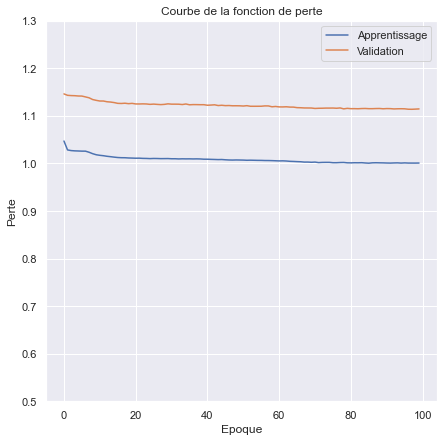

In [12]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Courbe de la fonction de perte')
plt.ylabel('Perte')
plt.xlabel('Epoque')
plt.ylim([0.5, 1.3])
_ = plt.legend(['Apprentissage', 'Validation'], loc='upper right')

**Reconstruction des erreurs sur les données d'apprentissage et calcul du seuil**

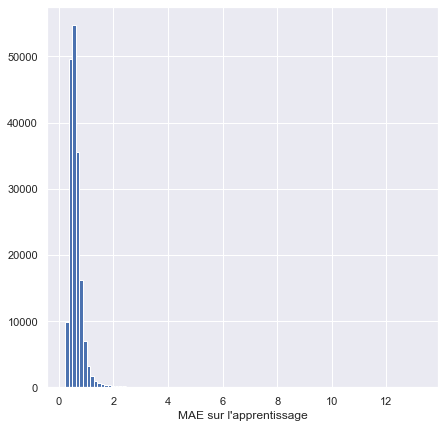

Seuil pour l'erreur de reconstruction : 1.33


In [13]:
# Calcul du MAE sur les données d'apprentissage

X_train_pred = vae.predict(X_train)
mae_train = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(mae_train, bins=100)
plt.xlabel("MAE sur l'apprentissage")
plt.show()

# Calcul du seuil
threshold = np.percentile(mae_train, 98)

print("Seuil pour l'erreur de reconstruction : {0:.2f}".format(threshold))

### Evaluation du modèle

#### Echantillon de validation

**Prédiction**

In [14]:
predictions = vae.predict(X_valid)

mse = np.mean(np.power(X_valid - predictions, 2), axis=1)
df_erreurs = pd.DataFrame({'mse': mse,
                           'y_true': Y_valid})
df_erreurs.describe()

,mse,y_true
count,45569.000000,45569.000000
mean,1.050366,0.001734
std,9.685787,0.041601
min,0.117284,0.000000
25%,0.373646,0.000000
50%,0.589482,0.000000
75%,0.933515,0.000000
max,1852.661424,1.000000


**Afficher les erreurs de prédictions sur la classe 1**

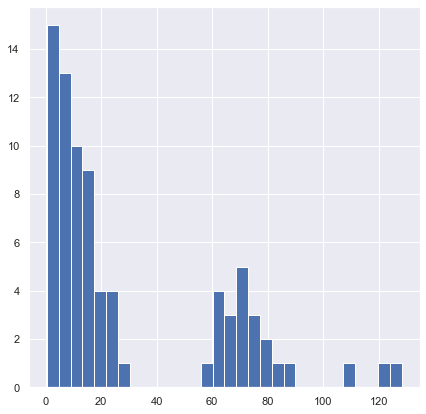

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
df_fraud_erreurs = df_erreurs[df_erreurs['y_true'] == 1]
_ = ax.hist(df_fraud_erreurs.mse.values, bins=30)

**Afficher la courbe ROC**

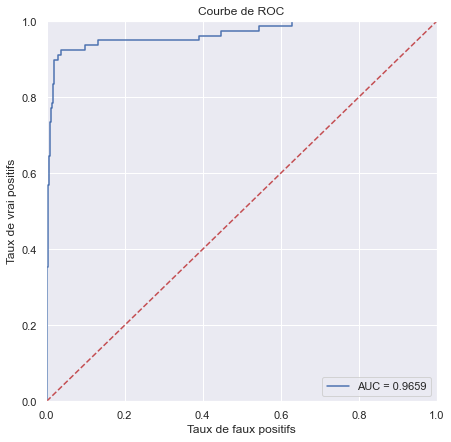

In [16]:
fpr, tpr, thresholds = roc_curve(df_erreurs.y_true, df_erreurs.mse)
roc_auc = auc(fpr, tpr)

plt.title('Courbe de ROC')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('Taux de vrai positifs')
plt.xlabel('Taux de faux positifs')
plt.show();

**Afficher la courbe Précision Recall**

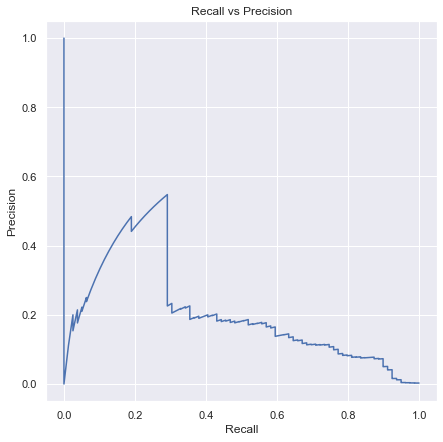

In [17]:
precision, recall, th = precision_recall_curve(df_erreurs.y_true, df_erreurs.mse)
plt.plot(recall, precision, 'b', label='Courbe precision-recall')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

**Afficher les performances du modèle**

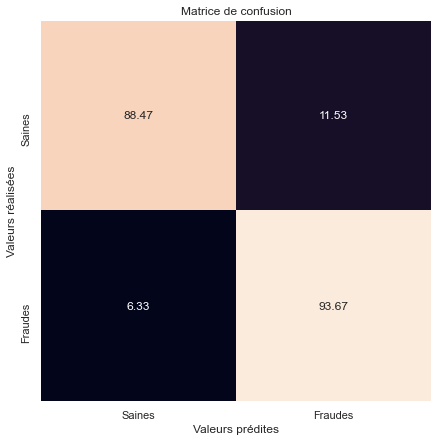

In [18]:
y_pred = [1 if e > threshold else 0 for e in df_erreurs.mse.values]
conf_matrix = confusion_matrix(df_erreurs.y_true, y_pred)
conf_matrix = 100 * conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt=".2f", cbar=False);
plt.title("Matrice de confusion")
plt.ylabel('Valeurs réalisées')
plt.xlabel('Valeurs prédites')
plt.show()

#### Echantillon de test

In [19]:
predictions = vae.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
df_erreurs = pd.DataFrame({'mse': mse,
                           'y_true': Y_test})
df_erreurs.describe()

,mse,y_true
count,56962.000000,56962.000000
mean,0.983981,0.001720
std,3.846177,0.041443
min,0.113189,0.000000
25%,0.371676,0.000000
50%,0.579004,0.000000
75%,0.919568,0.000000
max,313.930528,1.000000


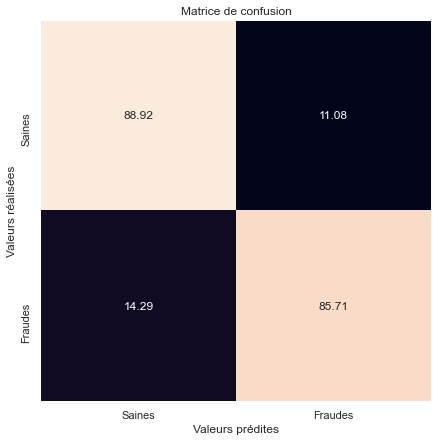

In [20]:
y_pred = [1 if e > threshold else 0 for e in df_erreurs.mse.values]
conf_matrix = confusion_matrix(df_erreurs.y_true, y_pred)
conf_matrix = 100 * conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt=".2f", cbar=False);
plt.title("Matrice de confusion")
plt.ylabel('Valeurs réalisées')
plt.xlabel('Valeurs prédites')
plt.show()

**Sources :**

[Timeseries anomaly detection using an Autoencoder](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)   
[Fraud Detection Using Autoencoders in Keras with a TensorFlow Backend](https://blogs.oracle.com/datascience/fraud-detection-using-autoencoders-in-keras-with-a-tensorflow-backend)    
[Modèles Génératifs et Auto-encodeurs variationnels](https://atcold.github.io/pytorch-Deep-Learning/fr/week08/08-3/)    
[Variational AutoEncoders for new fruits with Keras and Pytorch](https://becominghuman.ai/variational-autoencoders-for-new-fruits-with-keras-and-pytorch-6d0cfc4eeabd)   
[Making new Layers and Models via subclassing](https://colab.research.google.com/github/tensorflow/docs/blob/snapshot-keras/site/en/guide/keras/custom_layers_and_models.ipynb?authuser=1&hl=pt-BR#scrollTo=e2d97c7e31aa)